In [1]:
import datetime as dt
import bs4

import os

from bs4 import BeautifulSoup
import requests
import lxml.html as html

import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter
import time
import re

pd.options.display.max_columns = None
pd.options.display.max_rows=100

In [ ]:
os.getcwd()

# Análisis base: extracción de texto

## lectura de datos y conteo de registros por periódico
a partir de esto, se determinó que indagar en las estructyuras de milenio y los soles serían la mejor estrategia para abarcar más terreno

In [4]:
df = pd.read_csv('NUMV Agregado.csv',header=1)
df

C:\Users\hfgr1\AppData\Local\Temp\ipykernel_24612\3087241991.py:1: DtypeWarning: Columns (1,4,42,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('NUMV Agregado.csv',header=1)


,Modo,Año,No,ID,Fecha de tuit,Fecha de atropellamiento,Hora,Modo,Usuario,Nombre,Gen,Edad,Tipo vehículo,Marca,Modelo,Casco,Condición,Municipio,Zona metropolitana/conurbación,Estado,Entorno,Tipo de calle,Punto de accidente,Calle,Mapa,Latitud,Longitud,Tipo,Objeto,Mecánica,Días de hospitalizacion,Tipo Vehículo,Marca.1,Modelo.1,Género responsable,Edad responsable,Condición.1,Detenido,URL noticia,Seguimiento,Video,Relevantes,TW,Diasem,Tuit,,",",🚗,🚙,🚕,🚌,🚓,🚚,🚛,🏍️,🚲,🚶‍♀️,🚶‍♂️,[,],ago,-,Unnamed: 62,🚜,🚂
0,🚶‍♀️,2019,NaN,NaN,01-ene-19,01-ene-19,NaN,Peatón,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,Sin paso peatonal,Juan Pablo Etla,Oaxaca,Oaxaca,Suburbano,Avenida continua,Tramo,Carretera Internacional Oaxaca-Izúcar de Matam...,"https://www.google.com/maps/@17.1290249,-96.76...",17.1290249,-96.7695685,NaN,NaN,Cruce,NaN,NaN,NaN,NaN,NaN,NaN,Velocidad,Fugado,http://adnsureste.info/muere-persona-atropella...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,🚶‍♀️,2019,NaN,NaN,01-ene-19,01-ene-19,19:00,Peatón,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,Sin paso peatonal,Aguascalientes,Aguascalientes,Aguascalientes,Urbano,Avenida continua,Tramo,Av. Convención de 1914,"https://www.google.com/maps/@21.8689666,-102.2...",21.8689666,-102.2743995,NaN,NaN,Cruce,NaN,Camioneta pick-up,NaN,NaN,NaN,NaN,Velocidad,Detenido,https://noticieroelcirco.com/mujer-murio-atrop...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,🚶‍♀️,2019,NaN,NaN,01-ene-19,01-ene-19,NaN,Peatón,NaN,Manuel,H,3,NaN,NaN,NaN,NaN,NaN,Piedras Negras,Piedras Negras,Coahuila,Urbano,Calle local,Banqueta,Tamaulipas,"https://www.google.com/maps/@28.6481765,-100.5...",28.6481765,-100.5525747,NaN,NaN,NaN,NaN,Trailer,NaN,NaN,NaN,NaN,NaN,Fugado y detenido,https://www.siglo.mx/coahuila/noticia/256815.m...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,🚶‍♀️,2019,NaN,NaN,01-ene-19,01-ene-19,Noche,Peatón,NaN,NaN,H,40,NaN,NaN,NaN,NaN,NaN,Guaymas,Guaymas,Sonora,No urbano,Carretera,Tramo,Carretera Hermosillo-Guaymas,"https://www.google.com/maps/@28.0216599,-110.9...",28.0216599,-110.9312201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fugado,https://www.facebook.com/Red933MX/videos/36355...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,🚶‍♀️,2019,NaN,NaN,02-ene-19,01-ene-19,23:00,Peatón,NaN,Leopoldina,M,89,NaN,NaN,NaN,NaN,NaN,Coyuca de Benítez,No ZM,Guerrero,No urbano,Carretera,NaN,Carretera Acapulco-Zihuatanejo,"https://www.google.com/maps/@17.0117679,-100.1...",17.0117679,-100.1050258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fugado,https://novedadesaca.mx/muere-en-hospital-muje...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13794,🚶‍♀️,NaN,NaN,NaN,NaN,27-nov-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#¡VALOR!,#¡VALOR!,Atropellamiento,Vehículo motorizado,NaN,En sitio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13795,🚶‍♀️,NaN,NaN,NaN,NaN,27-nov-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#¡VALOR!,#¡VALOR!,Atropellamiento,Vehículo motorizado,NaN,En sitio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13796,🚶‍♀️,NaN,NaN,NaN,NaN,27-nov-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#¡VALOR!,#¡VALOR!,Atropellamiento,Vehículo motorizado,NaN,En sitio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [5]:
df['aux'] = df['URL noticia'].copy()

df['aux'] = df['aux'].str.replace('http://','')
df['aux'] = df['aux'].str.replace('https://','')

aux = df.loc[df.aux.notnull(),'aux'].str.split('/')
auxx = [x[0] for x in aux]

df['sitio'] = ''
df.loc[df.aux.notnull(),'sitio'] = [x for x in auxx]

In [10]:
auxxx = Counter(auxx)

df_aux = pd.DataFrame(
    {
    'site':auxxx.keys(),
    'freq':auxxx.values()
    }
)
del auxxx

df_aux = df_aux.sort_values('freq',ascending=False).reset_index(drop=True)

df_aux['pct'] = df_aux.freq/df_aux.freq.sum()

df_aux

,site,freq,pct
0,twitter.com,573,0.042201
1,www.milenio.com,432,0.031816
2,www.la-prensa.com.mx,206,0.015172
3,www.debate.com.mx,187,0.013772
4,periodicocorreo.com.mx,178,0.013109
...,...,...,...
1450,www.elredactor.mx,1,0.000074
1451,entornotvc.com.mx,1,0.000074
1452,www.rioaxaca.com,1,0.000074
1453,www.jornadabc.mx,1,0.000074


<BarContainer object of 1455 artists>

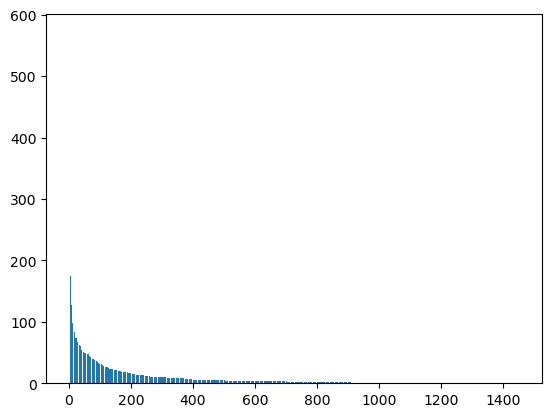

In [38]:
plt.bar(
    x=df_aux.index,
    height=df_aux.freq
)

## milenio

In [39]:
df_mil = df[df.sitio=='www.milenio.com']

aux_0 = df_mil.loc[df_mil['URL noticia'].notnull(),'URL noticia'].str.split(' y ')
auxx_0 = [x[0] for x in aux_0]

df_mil['url_0'] = auxx_0

df_mil['texto'] = ''

In [87]:
%%time

for i in df_mil.index:
    
    url = df_mil['url_0'][i]
    response = requests.get(url)
    home = response.content.decode('utf-8')
    parsed = html.fromstring(home)
    soup = BeautifulSoup(home, 'html.parser')
    
    aux = soup.find_all('title')[0].text
    
    for x in soup.find_all('p'):
        aux += ' '
        aux += x.text
        
    df_mil.loc[i, 'texto'] = aux

CPU times: total: 55.3 s
Wall time: 4min 18s


In [165]:
#df_mil['auxx'] = np.nan
df_mil['edad'] = np.nan
for i in df_mil.index:
#    df_mil.loc[i, 'auxx']
    if len(np.where(np.array(df_mil.texto_lista[i])=='años')[0])>0:
        auxxx = np.where(np.array(df_mil.texto_lista[i])=='años')[0][0] - 1
        df_mil.loc[i, 'edad'] = df_mil.texto_lista[i][auxxx]

C:\Users\hfgr1\AppData\Local\Temp\ipykernel_9320\1412701833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mil['edad'] = np.nan
C:\Users\hfgr1\AppData\Local\Temp\ipykernel_9320\1412701833.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mil.loc[i, 'edad'] = df_mil.texto_lista[i][auxxx]


In [131]:
df_mil['texto_0'] = df_mil['texto'].copy()

df_mil.texto_0 = df_mil.texto_0.str.lower()

df_mil.texto_0 = df_mil.texto_0\
    .str.replace('.','')\
    .str.replace(';','')\
    .str.replace(',','')\
    .str.replace('-','')\
    .str.replace('  ',' ')\
    .str.replace('  ',' ')\
    .str.replace('  ',' ')\
    .str.replace('  ',' ')\
    .str.replace('  ',' ')

C:\Users\hfgr1\AppData\Local\Temp\ipykernel_9320\2780758672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mil['texto_0'] = df_mil['texto'].copy()


## la prensa

In [96]:
df_prensa = df[df.sitio=='www.la-prensa.com.mx']

aux_0 = df_prensa.loc[df_prensa['URL noticia'].notnull(),'URL noticia'].str.split(' y ')
auxx_0 = [x[0] for x in aux_0]

df_prensa['url_0'] = auxx_0

df_prensa['texto'] = ''

C:\Users\hfgr1\AppData\Local\Temp\ipykernel_9320\3534606384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prensa['url_0'] = auxx_0
C:\Users\hfgr1\AppData\Local\Temp\ipykernel_9320\3534606384.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prensa['texto'] = ''


In [130]:
%%time

for i in df_prensa.index:
    
    url = df_prensa['url_0'][i]
    response = requests.get(url)
    home = response.content.decode('utf-8')
    parsed = html.fromstring(home)
    soup = BeautifulSoup(home, 'html.parser')
    
    try:
        aux = soup.find_all('title')[0].text
        aux += ' '
        aux += soup.find(class_='subtitle').text
        aux += ' '
        aux += soup.find(class_='content-body clearfix').text
        aux += ' '
        aux += soup.find(class_='content-continued-body clearfix').text
        
        df_prensa.loc[i, 'texto'] = aux
    except:
        1

CPU times: total: 12.8 s
Wall time: 1min 39s


In [510]:
for i in df_prensa.index[:30]:
    print(df_prensa.url_0[i])
    print(df_prensa.texto[i])

https://www.la-prensa.com.mx/policia/378926-muere-atropellado-joven-en-situacion-de-calle
Error - La Prensa | Noticias policiacas, locales, nacionales Error 404 No hemos podido encontrar la página que buscas. Sugerimos que revises tu URL, o puedes regresar a home.
https://www.la-prensa.com.mx/policia/390670-no-llegaron-atropellan-a-pareja-de-peregrinos-en-ixtapaluca
Error - La Prensa | Noticias policiacas, locales, nacionales Error 404 No hemos podido encontrar la página que buscas. Sugerimos que revises tu URL, o puedes regresar a home.
https://www.la-prensa.com.mx/policia/390670-no-llegaron-atropellan-a-pareja-de-peregrinos-en-ixtapaluca
Error - La Prensa | Noticias policiacas, locales, nacionales Error 404 No hemos podido encontrar la página que buscas. Sugerimos que revises tu URL, o puedes regresar a home.
https://www.la-prensa.com.mx/policia/396834-le-arrebatan-la-vida-a-damita-en-carriles-centrales-de-la-mexico-puebla
Error - La Prensa | Noticias policiacas, locales, nacionales 

## el sol de...

In [23]:
df_sol = df[df.sitio.str.contains('elsolde',case=False)]#.freq.sum()]

In [24]:
aux_0 = df_sol.loc[df_sol['URL noticia'].notnull(),'URL noticia'].str.split(' y ')
auxx_0 = [x[0] for x in aux_0]

df_sol['url_0'] = auxx_0

C:\Users\hfgr1\AppData\Local\Temp\ipykernel_24612\1947401964.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sol['url_0'] = auxx_0


In [25]:
for i in df_sol.index[:10]:
    print(df_sol.sitio[i])
    print(df_sol.url_0[i])

www.elsoldedurango.com.mx
https://www.elsoldedurango.com.mx/local/estremecedor-muere-atropellado-nino-de-2-anos-2869522.html
www.elsoldeacapulco.com.mx
https://www.elsoldeacapulco.com.mx/policiaca/muere-atropellado-en-el-poblado-de-la-sabana-acapulco-2916066.html
www.elsoldeparral.com.mx
https://www.elsoldeparral.com.mx/local/jimenez/muere-atropellado-un-adulto-mayor-2915557.html
www.elsoldelcentro.com.mx
https://www.elsoldelcentro.com.mx/policiaca/muere-arrollada-una-mujer-2921930.html
www.elsoldeacapulco.com.mx
https://www.elsoldeacapulco.com.mx/policiaca/muere-atropellado-en-bulevar-vicente-guerrero-accidente-chilpancingo-2925102.html
www.elsoldetijuana.com.mx
https://www.elsoldetijuana.com.mx/policiaca/muere-mujer-arrollada-en-la-rumorosa-2928067.html
www.elsoldehermosillo.com.mx
https://www.elsoldehermosillo.com.mx/policiaca/atropellan-a-tres-a-la-altura-del-cereso-2941674.html
www.elsoldeorizaba.com.mx
https://www.elsoldeorizaba.com.mx/policiaca/muere-atropellado-por-vehiculo-en-

In [135]:
url = 'https://www.elsoldetoluca.com.mx/policiaca/atropellan-a-peaton-que-intento-cruzar-la-autopis'

response = requests.get(url)
home = response.content.decode('utf-8')
parsed = html.fromstring(home)
soup = BeautifulSoup(home, 'html.parser')

In [137]:
texto = soup.find_all('title')[0].text
texto += ' '

try:
    texto += soup.find(class_='subtitle').text
    texto += ' '
except:
    1

gtm = soup.find_all('script')
for x in gtm:
    if 'dataLayer.push({"tags"' in x.text:
        gtm_tags = re.search('\$\[.*\]', x.text).group()
        gtm_tags = gtm_tags[2:-1]
        break
                
aux = soup.find(class_='content-body clearfix').find_all('p', class_=None)
for x in aux:
    if len(x.findChildren())<10:
        texto += x.text
        texto += ' '
        
auxx = soup.find(class_='content-continued-body clearfix').find_all('p', class_=None)
if auxx != aux:
    for x in auxx:
        if len(x.findChildren())<10:
            texto += x.text
            texto += ' '

#df_sol.loc[i, 'texto'] = texto
#df_sol.loc[i, 'tags'] = gtm_tags

AttributeError: 'NoneType' object has no attribute 'find_all'

In [134]:
texto

'Muere atropellado hombre de la tercera edad en bulevar Solidaridad - El Sol de Irapuato | Noticias Locales, Policiacas, de México, Guanajuato y el Mundo Un hombre de la tercera edad perdió la vida después de ser atropellado por un automóvil en el bulevar Solidaridad. El accidente ocurrió cerca de las 5:40 de la tarde de este viernes en el cruce semáforizado a la altura del cruce con Ejército Nacional.  \n\n\n\n\n\n\nEl hombre de aproximadamente 70 años quien hasta el momento no ha sido identificado iba a bordo de una bicicleta, vestía una sudadera color azul y un pantalón del mismo color.\n\n\n\n\n\n  El hombre de aproximadamente 70 años quien hasta el momento no ha sido identificado iba a bordo de una bicicleta, vestía una sudadera color azul y un pantalón del mismo color. Testigos indicaron que al cruzar la calle fue arrollado a velocidad considerable por el automóvil Chevrolet color blanco y cayó al menos 4 metros adelante, el impacto destrozó el parabrisas del lado derecho. El con

In [44]:
%%time

df_sol['texto'] = ''
df_sol['tags'] = ''

k=0
for i in df_sol.index:
    k+=1
    
    url = df_sol['url_0'][i]
    response = requests.get(url)
    home = response.content.decode('utf-8')
    parsed = html.fromstring(home)
    soup = BeautifulSoup(home, 'html.parser')
    
    try:
        texto = soup.find_all('title')[0].text
        texto += ' '
        
        texto += soup.find(class_='subtitle').text
        texto += ' '
        
        gtm = soup.find_all('script')
        for x in gtm:
            if 'dataLayer.push({"tags"' in x.text:
                gtm_tags = re.search('\$\[.*\]', x.text).group()
                gtm_tags = gtm_tags[2:-1]
                break
                        
        aux = soup.find(class_='content-body clearfix').find_all('p', class_=None)
        for x in aux:
            if len(x.findChildren())<10:
                texto += x.text
                texto += ' '
                
        auxx = soup.find(class_='content-continued-body clearfix').find_all('p', class_=None)
        if auxx != aux:
            for x in auxx:
                if len(x.findChildren())<10:
                    texto += x.text
                    texto += ' '
        
        df_sol.loc[i, 'texto'] = texto
        df_sol.loc[i, 'tags'] = gtm_tags
        
    except:
        1
    
    if k%50==0:
        print(k)

<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


50
100
150
200
250
300
350
400


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 7709: invalid continuation byte

In [35]:
df_sol['tags'] = df_sol['tags'].str.lower()

C:\Users\hfgr1\AppData\Local\Temp\ipykernel_24612\126245440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sol['tags'] = df_sol['tags'].str.lower()


In [42]:
tags = []
for x in df_sol['tags']:
    tags.extend(x.split(', '))

In [41]:
df_sol['tags'][9].split(', ')

['policiaca', 'durango', 'arrollado']

In [28]:
aux = soup.find(class_='content-body clearfix').find_all('p',class_=None)
for x in aux:
    if x.find(class_=None)!=None:
        print(x.find(class_=None).text)

Un hombre murió al ser atropellado por un vehículo en avenida 4 y calle 25,
El finado fue identificado como Francisco F., conocido como El Niño, de 58 años, de oficio mecánico.







el mecánico al parecer intentó cruzar la calle 

El ruletero tampoco se dio cuenta del peatón, por lo que inevitablemente lo arrolló y le causó la muerte.
Del accidente se notificó a los grupos de auxilio, quienes llegaron a valorar al mecánico, pero solo confirmaron su fallecimiento.







Policías del Estado llegaron al sitio para acordonar la zona y evitar algún contratiempo

Este fue llevado a la morgue en donde le sería practicada la autopsia


In [504]:
gtm_tags

['Arrollado', 'Muerto', 'Accidente Vial', 'Taxi']

## titulos

In [43]:
df_titles = df[['URL noticia']].copy()\
    .rename(columns={'URL noticia':'url'})
df_titles['title'] =''
df_titles = df_titles[df_titles.url.notnull()]

df_titles

,url,title
0,http://adnsureste.info/muere-persona-atropella...,
1,https://noticieroelcirco.com/mujer-murio-atrop...,
2,https://www.siglo.mx/coahuila/noticia/256815.m...,
3,https://www.facebook.com/Red933MX/videos/36355...,
4,https://novedadesaca.mx/muere-en-hospital-muje...,
...,...,...
13761,https://www.alertaqronoticias.com/2022/11/27/h...,
13762,https://imagendelgolfo.mx/policiaca/tren-habri...,
13763,https://mexico.quadratin.com.mx/auto-y-moto-ch...,
13764,https://surestesur.com/video-un-motociclista-m...,


In [ ]:
%%time

for i in df_titles.index[39:]:
    
    url = df_titles['url'][i]
    print(i)
    try:
        response = requests.get(url)
        print(response.status_code)
        
        if response.status_code == 200:
            try:
                home = response.content.decode('utf-8')
                parsed = html.fromstring(home)
                soup = BeautifulSoup(home, 'html.parser')
                
                aux = soup.find_all('title')
                if len(aux)>0:
                    df_titles.loc[i,'title'] = aux[0].string
                    
            except:
                1
    except:
        1

39
404
40
200
41
200
42
200
43
200
44
404
45
46
200
47
403
48
200
49
200
50
200
51
404
52
404
53
200
54
200
55
404
56
403
57
200
58
200
59
404
60
404
61
200
62
63
200
64
200
65
200
66
406
67
200
68
200
69
404
70
200
71
200
72
404
73
200
74
200
75
200
76
200
77
404
78
79
200
80
200
81
200
82
403
83
200
84
404
85
404
86
200
87
404
88
200
89
200
90
403
91
404
92
404
93
403
94
200
95
200
96
200
97
200
98
200
99
200
100
200
101
200
102
406
103
404
104
200
105
200
106
200
107
200
108
200
109
200
110
403
111
200
112
200
113
404
114
200
115
200
116
200
117
200
118
404
119
200
120
200
121
200
122
200
123
200
124
200
125
200
126
200
127
200
128
200
129
200
130
200
131
200
132
200
133
200
134
200
135
200
136
200
137
200
138
404
139
200
140
200
141
200
142
200
143
200
144
403
145
200
146
200
147
200
148
200
149
200
150
200
151
500
152
406
153
406
154
404
155
200
156
406
157
200
158
200
159
404
160
404
161
200
162
200
163
403
164
200
165
200
166
200
167
200
168
522
169
200
170
200
171
404
172
404
1

404
1084
200
1085
400
1086
404
1087
200
1088
200
1089
200
1090
200
1091
404
1092
200
1093
200
1094
200
1095
200
1096
200
1097
404
1098
200
1099
403
1100
200
1101
1102
404
1103
404
1104
404
1105
200
1106
200
1107
1108
200
1109
404
1110
404
1111
200
1112
200
1113
404
1114
404
1115
404
1116
200
1117
404
1118
404
1119
200
1120
404
1121
1122
404
1123
200
1124
400
1125
200
1126
522
1127
404
1128
404
1129
404
1130
403
1131
404
1132
200
1133
404
1134
404
1135
200
1136
200
1137
404
1138
404
1139
200
1140
404
1141
404
1142
200
1143
200
1144
200
1145
200
1146
404
1147
404
1148
200
1149
200
1150
200
1151
1152
404
1153
200
1154
404
1155
200
1156
400
1157
200
1158
200
1159
404
1160
200
1161
404
1162
404
1163
200
1164
404
1165
406
1166
404
1167
404
1168
200
1169
200
1170
200
1171
406
1172
200
1173
404
1174
404
1175
200
1176
1177
404
1178
404
1179
404
1180
200
1181
200
1182
200
1183
200
1184
200
1185
520
1186
404
1187
200
1188
200
1189
404
1190
1191
404
1192
404
1193
200
1194
200
1195
1196
404
1197
40

404
2012
200
2013
200
2014
200
2015
403
2016
2017
200
2018
200
2019
404
2020
200
2021
404
2022
404
2023
400
2024
400
2025
400
2026
404
2027
403
2028
200
2029
404
2030
404
2031
200
2032
200
2033
404
2034
404
2035
200
2036
404
2037
200
2038
200
2039
404
2040
200
2041
200
2042
2043
400
2044
200
2045
404
2046
404
2047
200
2048
200
2049
404
2050
200
2051
200
2052
404
2053
404
2054
200
2055
404
2056
404
2057
403
2058
404
2059
404
2060
403
2061
200
2062
404
2063
404
2064
404
2065
404
2066
2067
200
2068
200
2069
404
2070
200
2071
503
2072
404
2073
404
2074
404
2075
404
2076
406
2077
404
2078
403
2079
404
2080
404
2081
404
2082
404
2083
200
2084
400
2085
2086
404
2087
404
2088
522
2089
200
2090
200
2091
404
2092
404
2093
404
2094
404
2095
200
2096
200
2097
404
2098
200
2099
200
2100
200
2101
200
2102
404
2103
200
2104
200
2105
404
2106
200
2107
404
2108
404
2109
404
2110
522
2111
200
2112
404
2113
404
2114
200
2115
520
2116
404
2117
200
2118
400
2119
404
2120
400
2121
400
2122
404
2123
200
2124

403
2941
200
2942
400
2943
200
2944
403
2945
200
2946
200
2947
400
2948
200
2949
404
2950
404
2951
200
2952
200
2953
404
2954
200
2955
200
2956
200
2957
200
2958
200
2959
400
2960
403
2961
404
2962
404
2963
200
2964
404
2965
404
2966
404
2967
404
2968
200
2969
404
2970
404
2971
404
2972
404
2973
404
2974
404
2975
404
2976
404
2977
200
2978
404
2979
404
2980
404
2981
403
2982
404
2983
200
2984
404
2985
200
2986
404
2987
404
2988
200
2989
200
2990
403
2991
404
2992
200
2993
200
2994
200
2995
404
2996
404
2997
200
2998
404
2999
404
3000
404
3001
403
3002
200
3003
404
3004
404
3005
403
3006
200
3007
200
3008
200
3009
400
3010
500
3011
404
3012
200
3013
404
3014
200
3015
404
3016
404
3017
404
3018
404
3019
404
3020
200
3021
404
3022
200
3023
200
3024
200
3025
404
3026
404
3027
200
3028
404
3029
404
3030
200
3031
200
3032
200
3033
200
3034
200
3035
200
3036
404
3037
404
3038
404
3039
200
3040
200
3041
200
3042
200
3043
200
3044
404
3045
400
3046
404
3047
400
3048
200
3049
3050
200
3051
404
3

200
3859
200
3860
200
3861
200
3862
200
3863
200
3864
200
3865
200
3866
200
3867
200
3868
200
3869
200
3870
200
3871
200
3872
404
3873
200
3874
403
3875
200
3876
200
3877
200
3878
403
3879
200
3880
200
3881
403
3882
403
3883
200
3884
200
3885
200
3886
406
3887
200
3888
200
3889
200
3890
200
3891
200
3892
403
3893
200
3894
200
3895
200
3896
200
3897
200
3898
200
3899
200
3900
400
3901
200
3902
200
3903
200
3904
200
3905
200
3906
200
3907
404
3908
200
3909
200
3910
200
3911
200
3912
200
3913
200
3914
200
3915
200
3916
200
3917
200
3918
200
3919
404
3920
200
3921
200
3922
200
3923
200
3924
200
3925
200
3926
200
3927
404
3928
200
3929
200
3930
3931
200
3932
200
3933
200
3934
200
3935
200
3936
200
3937
200
3938
200
3939
403
3940
200
3941
404
3942
404
3943
200
3944
403
3945
500
3946
200
3947
200
3948
200
3949
200
3950
200
3951
200
3952
200
3953
200
3954
200
3955
200
3956
404
3957
200
3958
200
3959
200
3960
200
3961
200
3962
200
3963
200
3964
200
3965
200
3966
200
3967
200
3968
200
3969
200
3

522
4780
200
4781
200
4782
404
4783
200
4784
200
4785
4786
200
4787
200
4788
404
4789
200
4790
200
4791
200
4792
200
4793
200
4794
404
4795
200
4796
200
4797
200
4798
403
4799
200
4800
200
4801
406
4802
200
4803
4804
404
4805
200
4806
404
4807
200
4808
200
4809
200
4810
200
4811
404
4812
404
4813
200
4814
200
4815
200
4816
200
4817
200
4818
404
4819
404
4820
404
4821
200
4822
403
4823
200
4824
200
4825
404
4826
200
4827
403
4828
200
4829
200
4830
200
4831
200
4832
200
4833
200
4834
200
4835
200
4836
200
4837
200
4838
200
4839
200
4840
200
4841
200
4842
200
4843
404
4844
404
4845
200
4846
200
4847
200
4848
200
4849
404
4850
200
4851
200
4852
200
4853
200
4854
406
4855
403
4856
200
4857
200
4858
200
4859
200
4860
200
4861
200
4862
406
4863
200
4864
200
4865
4866
200
4867
200
4868
200
4869
404
4870
4871
404
4872
404
4873
200
4874
404
4875
404
4876
404
4877
406
4878
200
4879
200
4880
200
4881
200
4882
403
4883
200
4884
200
4885
200
4886
200
4887
406
4888
200
4889
403
4890
200
4891
404
4892

200
5701
404
5702
200
5703
403
5704
404
5705
406
5706
403
5707
200
5708
200
5709
404
5710
404
5711
200
5712
404
5713
200
5714
404
5715
200
5716
404
5717
5718
200
5719
200
5720
200
5721
404
5722
404
5723
404
5724
404
5725
200
5726
404
5727
200
5728
200
5729
406
5730
200
5731
404
5732
200
5733
200
5734
404
5735
404
5736
403
5737
200
5738
404
5739
404
5740
5741
200
5742
404
5743
404
5744
200
5745
5746
404
5747
404
5748
404
5749
404
5750
404
5751
403
5752
200
5753
200
5754
200
5755
200
5756
200
5757
200
5758
200
5759
404
5760
404
5761
404
5762
404
5763
200
5764
400
5765
200
5766
404
5767
200
5768
404
5769
200
5770
404
5771
200
5772
200
5773
200
5774
200
5775
200
5776
200
5777
200
5778
404
5779
404
5780
404
5781
404
5782
404
5783
404
5784
404
5785
200
5786
404
5787
404
5788
404
5789
404
5790
404
5791
404
5792
404
5793
200
5794
403
5795
406
5796
403
5797
404
5798
200
5799
200
5800
200
5801
200
5802
406
5803
200
5804
200
5805
200
5806
200
5807
200
5808
403
5809
200
5810
404
5811
403
5812
404


In [67]:
df_titles['aux'] = df_titles.url.str.slice(0,3)
df_titles.loc[df_titles.aux=='www','url'] = 'https://'+df_titles.loc[df_titles.aux=='www','url']

In [11]:
url = df['URL noticia'][0]
with open(url, 'r') as f:
    contents = f.read()
    soup = BeautifulSoup(contents, 'html.parser')

OSError: [Errno 22] Invalid argument: 'http://adnsureste.info/muere-persona-atropellada-en-la-carretera-federal-190-a-la-altura-de-la-joya-1625-h/'

In [7]:
with open('metropoli_pag.html', 'r',encoding='utf-8') as f:
    contents = f.read()
    soup = BeautifulSoup(contents, 'html.parser')

In [37]:
links = [link.get('href') for link in soup.find_all('a') if link.get('href')[:41]=='https://www.eluniversal.com.mx/metropoli/']

In [41]:
set(links)

{'https://www.eluniversal.com.mx/metropoli/asi-fue-el-ultimo-domingo-de-la-palma-centenaria-en-reforma',
 'https://www.eluniversal.com.mx/metropoli/asi-puedes-obtener-la-tarjeta-de-circulacion-digital-en-cdmx',
 'https://www.eluniversal.com.mx/metropoli/cruz-azul-atletico-san-luis-sin-detenidos-rina-entre-aficionados-en-partido',
 'https://www.eluniversal.com.mx/metropoli/cualquier-feminicidio-duele-dice-sheinbaum-al-anunciar-que-el-lunes-daran-balance-de-alerta-de-genero',
 'https://www.eluniversal.com.mx/metropoli/dan-prision-preventiva-oficiosa-integrantes-de-la-okupa-que-agredieron-una-mujer',
 'https://www.eluniversal.com.mx/metropoli/debanhi-escobar-mujeres-protestan-en-la-fiscalia-cdmx-por-feminicidios',
 'https://www.eluniversal.com.mx/metropoli/en-15-anos-van-247-mil-abortos-en-la-cdmx',
 'https://www.eluniversal.com.mx/metropoli/en-un-mes-habra-un-nuevo-ejemplar-estima-sedema',
 'https://www.eluniversal.com.mx/metropoli/familias-triquis-se-enfrentan-con-policias-de-la-cdmx-de

In [30]:
links[100]

'https://www.eluniversal.com.mx/metropoli/panteon-de-donde-sacaron-tadeo-con-accesos-clandestinos'

In [31]:
links[100][:40]

'https://www.eluniversal.com.mx/metropoli'

# Clasificación de accidentados (bici-moto-peatón)
Una vez extraído el texto de los sitios, se busca una regla de deicsión para clasificar los casos según el medio de transporte de la víctima

In [4]:
df = pd.read_csv('df_output.csv')
df.head()

C:\Users\hfgr1\AppData\Local\Temp\ipykernel_18860\1385507144.py:1: DtypeWarning: Columns (2,5,43,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_output.csv')


,Unnamed: 0,Modo,Año,No,ID,Fecha de tuit,Fecha de atropellamiento,Hora,Modo,Usuario,...,sitio,milenio_dummy,elsol_dummy,url_0,texto,tags,status_code,texto_0,texto_lista,edad
0,0,🚶‍♀️,2019,NaN,NaN,01-ene-19,01-ene-19,NaN,Peatón,NaN,...,adnsureste.info,False,False,http://adnsureste.info/muere-persona-atropella...,NaN,NaN,NaN,NaN,[''],NaN
1,1,🚶‍♀️,2019,NaN,NaN,01-ene-19,01-ene-19,19:00,Peatón,NaN,...,noticieroelcirco.com,False,False,https://noticieroelcirco.com/mujer-murio-atrop...,NaN,NaN,NaN,NaN,[''],NaN
2,2,🚶‍♀️,2019,NaN,NaN,01-ene-19,01-ene-19,NaN,Peatón,NaN,...,www.siglo.mx,False,False,https://www.siglo.mx/coahuila/noticia/256815.m...,NaN,NaN,NaN,NaN,[''],NaN
3,3,🚶‍♀️,2019,NaN,NaN,01-ene-19,01-ene-19,Noche,Peatón,NaN,...,www.facebook.com,False,False,https://www.facebook.com/Red933MX/videos/36355...,NaN,NaN,NaN,NaN,[''],NaN
4,4,🚶‍♀️,2019,NaN,NaN,02-ene-19,01-ene-19,23:00,Peatón,NaN,...,novedadesaca.mx,False,False,https://novedadesaca.mx/muere-en-hospital-muje...,NaN,NaN,NaN,NaN,[''],NaN


## regla de decisión actual

In [214]:
si_moto = ['-a-moto','motociclista-tras','motocilcista-al']
no_moto = ['por-moto','por-una-moto']

In [6]:
df['texto_1'] = ''
df.loc[df.texto_0.notnull(), 'texto_1'] = df.loc[df.texto_0.notnull(), 'texto_0']

In [228]:
df['URL noticia 0'] = df['URL noticia'].copy()
df.loc[df['URL noticia'].isnull(), 'URL noticia 0'] = ''

In [243]:
for i in df[(df['Modo_0']=='peaton')&(df.modo=='moto')&(df.texto.notnull())].index:
    print(df.loc[i,'url_0'])

https://www.elsoldeorizaba.com.mx/policiaca/muere-enfermera-tras-impacto-de-motoclista-en-orizaba-3004826.html
https://www.elsoldesanjuandelrio.com.mx/policiaca/muere-mujer-atropellada-3008628.html?utm_content=buffer25144&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer
https://www.elsoldeirapuato.com.mx/policiaca/muere-mujer-atropellada-en-penjamo-3169977.html
https://www.elsoldesanjuandelrio.com.mx/policiaca/hombre-murio-atropellado-sobre-la-carretera-120-3227978.html?utm_content=bufferb9023&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer
https://www.elsoldeirapuato.com.mx/policiaca/identifican-a-hombre-atropellado-en-carretera-irapuato-abasolo-3236387.html
https://www.milenio.com/policia/muere-mujer-de-la-tercera-edad-arrollada-por-un-camion
https://www.elsoldetlaxcala.com.mx/policiaca/mueren-dos-mujeres-en-carrera-de-carcachas-de-xaloztoc-4244291.html
https://www.milenio.com/policia/hombre-muere-atropellado-en-calle-de-huixquilucan
https://www.elsoldetoluca

In [257]:
df['modo'] = 'peaton'
df.loc[df.texto_1.str.contains('cicl[ei]', case=False, regex=True), 'modo'] = 'bici'


df.loc[
    (df.texto_1.str.contains('moto[^r]', case=False, regex=True)) &
    ~(df['URL noticia 0'].str.contains('por-moto|por-una-moto', case=False, regex=True))
    , 'modo'] = 'moto'

for x in si_moto:
    df.loc[df['URL noticia 0'].str.contains(x, case=False, regex=True), 'modo'] = 'moto'
    
df.loc[df.texto_1=='', 'modo'] = ''

In [219]:
df.loc[df.texto_1.str.contains('camina|peat', case=False, regex=True), 'modo'] = 'peaton'

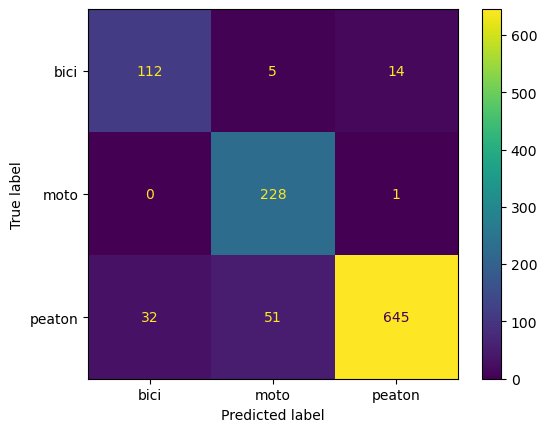

In [258]:
cm = confusion_matrix(df[df.texto.notnull()].Modo_0,
                      df[df.texto.notnull()].modo,
                     labels=['bici','moto','peaton'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                     display_labels=['bici','moto','peaton'])
#                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [34]:
df['dummy_motociclista'] = df.texto_0.str.contains('motoci', case=False, regex=True)
df['dummy_ciclista'] = df.texto_0.str.contains('cicl[ei]', case=False, regex=True)
df.loc[(df.dummy_motociclista)&(df.dummy_motociclista.notnull()),'dummy_ciclista'] = False

df.loc[df.dummy_motociclista.isnull(), 'dummy_motociclista'] = False
df.loc[df.dummy_ciclista.isnull(), 'dummy_ciclista'] = False
#df['dummy_peaton'] = 

In [67]:
df['dummy_moto'] = df.texto_0.str.contains('moto', case=False, regex=True)
df.loc[df.dummy_moto.isnull(), 'dummy_moto'] = False

In [68]:
df['modoo'] = df.modo.copy()
df.loc[df.dummy_moto, 'modoo'] = 'moto'

In [39]:
df['modo'] = 'peaton?'
df.loc[df.dummy_motociclista, 'modo'] = 'moto'
df.loc[df.dummy_ciclista, 'modo'] = 'bici'

In [31]:
df['dummy_ciclista'] = df.texto_0.str.contains('cicl[ei]', case=False, regex=True)

In [32]:
df.loc[df.dummy_ciclista.isnull(), 'dummy_ciclista'] = False

## ngramas y sus frecuencias

In [160]:
# Creating a function to generate N-Grams
def generate_ngrams(text, WordsToCombine, split_char=''):
     words = text.split(split_char)
     output = []  
     for i in range(len(words)- WordsToCombine+1):
         output.append(words[i:i+WordsToCombine])
     return output

# Calling the function
#generate_ngrams(text='this is a very good book to study', WordsToCombine=3)

In [139]:
lista_ngram_moto = []

for i in df[(df['Modo_0']=='peaton')&(df.modo=='moto')&(df.texto.notnull())].index:

    ngram_list = generate_ngrams(df.texto_0[i],3)

#    auxy = []
    for ngram in ngram_list:
        aux_ngram = ''
        for y in ngram:
            aux_ngram += ' '
            aux_ngram += y
        
        if 'moto' in aux_ngram:
            lista_ngram_moto.append(aux_ngram)

In [179]:
lista_ngram_peaton = []

for i in df[(df['Modo_0']=='peaton')].index:
    
    if df['URL noticia'][i] is not np.nan:
    
        ngram_list = generate_ngrams(df['URL noticia'][i],3,'-')
    
    #    auxy = []
        for ngram in ngram_list:
            aux_ngram = ''
            for y in ngram:
                aux_ngram += ' '
                aux_ngram += y
            
            if 'moto' in aux_ngram:
                lista_ngram_peaton.append(aux_ngram)

In [181]:
df_ngrams_tipos = pd.DataFrame(data={    
    'palabra': Counter(lista_ngram_moto).keys(),
   'frec': Counter(lista_ngram_moto).values()
})
df_ngrams_tipos['tipo'] = 'moto'

aux = pd.DataFrame(data={    
    'palabra': Counter(lista_ngram_bici).keys(),
   'frec': Counter(lista_ngram_bici).values()
})
aux['tipo'] = 'bici'

df_ngrams_tipos = pd.concat([df_ngrams_tipos,aux], ignore_index=True)

aux = pd.DataFrame(data={    
    'palabra': Counter(lista_ngram_peaton).keys(),
   'frec': Counter(lista_ngram_peaton).values()
})
aux['tipo'] = 'peaton'

df_ngrams_tipos = pd.concat([df_ngrams_tipos,aux], ignore_index=True)

df_ngrams_tipos

,palabra,frec,tipo
0,https://lineadirectaportal.com/policiaca/muer...,1,moto
1,motociclista atropellado en,42,moto
2,https://www.elnorte.com/libre/acceso/accesofb...,1,moto
3,motociclista arrollado por,49,moto
4,https://www.elsoldesalamanca.com.mx/policiaca...,1,moto
...,...,...,...
3869,un motociclista/ y https://periodicocorreo.co...,1,peaton
3870,motociclista/ y https://periodicocorreo.com.m...,1,peaton
3871,mujer caer motocicleta,1,peaton
3872,caer motocicleta miguel,1,peaton


In [191]:
df_ngrams_tipos_pivot = df_ngrams_tipos.pivot(index='palabra',columns='tipo').frec.reset_index().fillna(0)

In [196]:
df_ngrams_tipos_pivot_pct = df_ngrams_tipos_pivot.copy()

df_ngrams_tipos_pivot_pct['moto'] = df_ngrams_tipos_pivot_pct['moto'] / df_ngrams_tipos_pivot_pct['moto'].sum()
df_ngrams_tipos_pivot_pct['bici'] = df_ngrams_tipos_pivot_pct['bici'] / df_ngrams_tipos_pivot_pct['bici'].sum()
df_ngrams_tipos_pivot_pct['peaton'] = df_ngrams_tipos_pivot_pct['peaton'] / df_ngrams_tipos_pivot_pct['peaton'].sum()

In [197]:
df_ngrams_tipos_pivot_pct

tipo,palabra,bici,moto,peaton
0,y https://abcnoticias.mx/muere motociclista,0.0,0.000390,0.000000
1,y https://noticieros.televisa.com/videos/mo...,0.0,0.000195,0.000000
2,y https://pipolmexico.com/2022/06/11/muere ...,0.0,0.000195,0.000000
3,20220221 0052.html y https://www.tribuna.com...,0.0,0.000195,0.000000
4,https://www.elsoldeirapuato.com.mx/policiaca...,0.0,0.000195,0.000000
...,...,...,...,...
3734,yucatan/pareja en motocicleta,0.0,0.000390,0.000000
3735,zamora/ y https://noticiasalertamichoacan.com...,0.0,0.000000,0.000989
3736,zaragoza cdmx/ y https://www.elgrafico.mx/la ...,0.0,0.000195,0.000000
3737,zaragoza muere motociclista,0.0,0.000195,0.000000


CPU times: total: 31.2 ms
Wall time: 15.9 ms


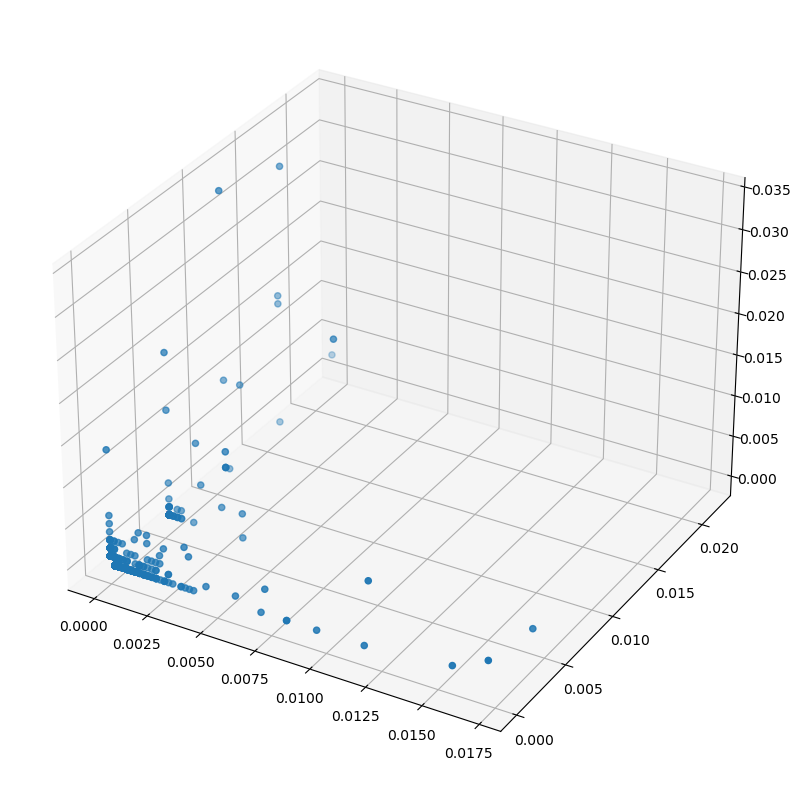

In [199]:
%%time
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
#ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
#ax.set_position([0, 0, 0.95, 1])
ax.scatter(
    df_ngrams_tipos_pivot_pct.moto,
    df_ngrams_tipos_pivot_pct.bici,
    df_ngrams_tipos_pivot_pct.peaton,
#    c=im_agg[['cc0','cc1','cc2']]/10,
#    s=im_agg.conteo_norm*300
)

In [206]:
aux = df_ngrams_tipos.groupby('tipo').frec.sum().reset_index().rename(columns={'frec':'total'})
aux

,tipo,total
0,bici,184
1,moto,5123
2,peaton,1011


In [207]:
df_ngrams_tipos = df_ngrams_tipos.merge(aux, on='tipo')

In [209]:
df_ngrams_tipos['pct'] = df_ngrams_tipos.frec / df_ngrams_tipos.total

In [213]:
df_ngrams_tipos.sort_values('pct',ascending=False).head(30).pivot(index='palabra',columns='tipo',values='pct')

tipo,bici,moto,peaton
palabra,,,
a motociclista en,NaN,0.016787,NaN
al chocar motocicleta,0.010870,NaN,NaN
arrollado por motocicleta,0.021739,NaN,NaN
arrollado por motociclista,NaN,NaN,0.012859
atropellada por motociclista,NaN,NaN,0.013848
atropellado por motociclista,0.016304,NaN,0.015826
chocar motocicleta contra,0.010870,NaN,NaN
mata a motociclista,NaN,0.011712,NaN
motocicleta en navojoa,0.010870,NaN,NaN


In [211]:
df_ngrams_tipos.sort_values('pct',ascending=False).head(50)

,palabra,frec,tipo,total,pct
3208,por motociclista en,34,peaton,1011,0.033630
3179,por un motociclista,32,peaton,1011,0.031652
3048,arrollado por motocicleta,4,bici,184,0.021739
3180,un motociclista en,20,peaton,1011,0.019782
3177,por una motocicleta,20,peaton,1011,0.019782
25,motociclista tras ser,88,moto,5123,0.017177
42,a motociclista en,86,moto,5123,0.016787
3018,por un mototaxi,3,bici,184,0.016304
3036,por un motociclista,3,bici,184,0.016304
3023,por una moto,3,bici,184,0.016304


In [144]:
lista_ngram_moto_freq = pd.DataFrame(data={    
    'palabra': Counter(lista_ngram_moto).keys(),
   'frec': Counter(lista_ngram_moto).values()
})

lista_ngram_moto_freq.sort_values('frec',ascending=False).head(100)

,palabra,frec
46,de una motocicleta,11
35,de su motocicleta,3
3,por un motociclista,3
26,en una motocicleta,3
65,policiaca muere motociclista,3
191,otro motorista que,2
196,encontronazo entre motorista,2
27,una motocicleta de,2
31,motociclista arrolla a,2
190,a otro motorista,2


In [158]:
aux = df.texto_0.str.contains('de una motoc')
aux[aux.isnull()] = False
for i in df[aux].index:
    print(df[' Modo '][i])
    print(df['modo'][i])
    print(df.url_0[i])
#    print(df.texto[i])

🚶‍♀️
moto
https://www.milenio.com/policia/muere-mujer-de-la-tercera-edad-arrollada-por-un-camion
🚶‍♀️
moto
https://www.elsoldeacapulco.com.mx/policiaca/identifican-a-hombre-atropellado-en-san-marcos-policiaca-accidente-violencia-4478216.html
🚶‍♀️
peaton
https://www.milenio.com/policia/durango-empujaba-su-motocicleta-es-arrollado-y-muere
🚶‍♀️
moto
https://www.milenio.com/policia/muere-septuagenaria-atropellada-por-ruta-21
🚶‍♀️
peaton
https://www.milenio.com/policia/tlaquepaque-hombre-muere-atropellado-colonia-san-pedrito_2
🚶‍♀️
moto
https://www.elsoldelcentro.com.mx/policiaca/fallece-un-menor-en-lamentable-accidente-tras-ser-atropellado-5205432.html
🚶‍♀️
moto
https://www.elsoldelcentro.com.mx/policiaca/fallecio-motociclista-y-quien-intento-ayudarlo-5453012.html
🚶‍♀️
moto
https://www.elsoldetoluca.com.mx/policiaca/muere-mujer-presuntamente-atropellada-en-la-penon-texcoco-5936177.html
🏍️
moto
https://www.elsoldesalamanca.com.mx/policiaca/muere-joven-atropellado-accidente-atropellado-muert

## frecuencias por palabra

In [56]:
df['texto_0'] = df['texto_0'].str.replace(':','').str.replace(';','')

In [59]:
df['texto_lista'] = df.texto_0.str.split(' ')

In [ ]:
df.Modo_0=='peaton'

In [105]:
lista_total = []
for x in df[(df.texto.notnull()) & (df.Modo_0=='peaton')].texto_lista:
    lista_total += x

lista_freq = pd.DataFrame(data={    
    'palabra': Counter(lista_total).keys(),
   'frec': Counter(lista_total).values()
})

lista_freq.sort_values('frec',ascending=False)[:100]

,palabra,frec
4,de,12904
47,la,8624
7,el,6341
23,en,4448
56,a,4188
60,que,3723
16,y,3439
26,del,3042
51,por,2458
30,se,2424


In [83]:
palabras_inutiles = lista_freq.sort_values('frec',ascending=False).head(18).palabra.tolist()

In [84]:
#  genera base de variables indicadoras por palabra
#V es una matriz
vectorizer=CountVectorizer()
V = vectorizer.fit_transform(df[df['texto_0'].notnull()]['texto_0'].values.astype('U'))
# lista de palabras
lista_palabras = vectorizer.get_feature_names()
# conteo de palabras
conteo_lista_palabras=pd.Series(
    V.sum(axis=0).tolist()[0],
    index=lista_palabras
)
conteo_lista_palabras_3 = conteo_lista_palabras.iloc[np.where(pd.Series(
                                                        [len(omg) for omg in conteo_lista_palabras.index.values.tolist()]
                                                        )>2)]
#subset de utiles
lista_palabras_subset = list(
set(conteo_lista_palabras_3.index.values.tolist()
).difference(
    set(palabras_inutiles)
).difference(
    set(['i','thi','&'])
))
freqs=conteo_lista_palabras_3[lista_palabras_subset]

C:\ProgramData\Anaconda3\envs\base_2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<BarContainer object of 1119 artists>

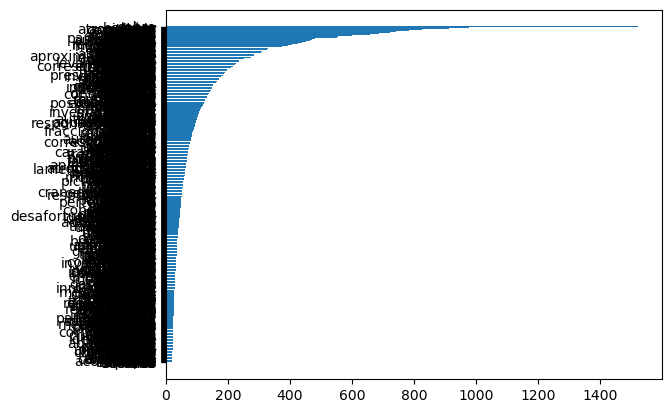

In [97]:
plt.barh(
    y=freqs[freqs>20].sort_values().index,
    width=freqs[freqs>20].sort_values().values)

## primera clasficiación

In [25]:
df['Modo_0'] = 'peaton'
df.loc[ df[' Modo ']=='🏍️', 'Modo_0'] = 'moto'
df.loc[ df[' Modo ']=='🚲', 'Modo_0'] = 'bici'

In [15]:
df.loc[ df[' Modo ']=='🚶\u200d♀️', 'Modo_0'] = 'peaton?

Object `peaton` not found.


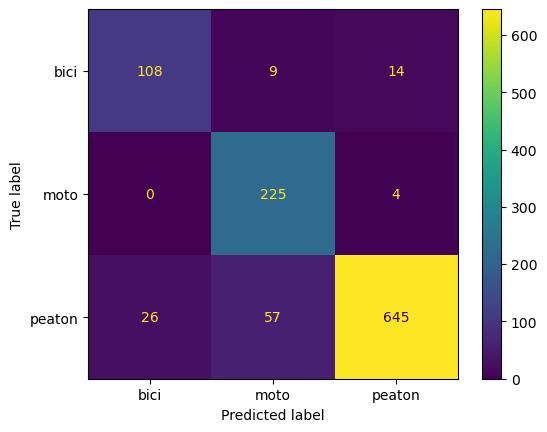

In [40]:
cm = confusion_matrix(df[df.texto.notnull()].Modo_0,
                      df[df.texto.notnull()].modo,
                     labels=['bici','moto','peaton'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                     display_labels=['bici','moto','peaton'])
#                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [14]:
df[' Modo '].unique()

array(['🚶\u200d♀️', '🚲', '🏍️'], dtype=object)

In [80]:
dfff = pd.read_csv('NUMV Agregado.csv',header=1)
dfff = dfff[[' No ', ' ID ', 'URL noticia']]

dfff['aux'] = dfff['URL noticia'].copy()
dfff['aux'] = dfff['aux'].str.replace('http://','')
dfff['aux'] = dfff['aux'].str.replace('https://','')

aux = dfff.loc[dfff.aux.notnull(),'aux'].str.split('/')
auxx = [x[0] for x in aux]

dfff['sitio'] = ''
dfff.loc[dfff.aux.notnull(),'sitio'] = [x for x in auxx]

C:\Users\hfgr1\AppData\Local\Temp\ipykernel_24612\355173164.py:1: DtypeWarning: Columns (1,4,42,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  dfff = pd.read_csv('NUMV Agregado.csv',header=1)


In [82]:
dfff[7900:8000]

,No,ID,URL noticia,aux,sitio
7900,NaN,NaN,https://guanajuato.lasillarota.com/estados/dos...,guanajuato.lasillarota.com/estados/dos-motocic...,guanajuato.lasillarota.com
7901,NaN,NaN,https://guanajuato.lasillarota.com/estados/dos...,guanajuato.lasillarota.com/estados/dos-motocic...,guanajuato.lasillarota.com
7902,NaN,NaN,https://periodicocorreo.com.mx/muere-motocicli...,periodicocorreo.com.mx/muere-motociclista-tras...,periodicocorreo.com.mx
7903,1541.0,NaN,https://www.forotv.mx/matutino-express/trabaja...,www.forotv.mx/matutino-express/trabajador-de-g...,www.forotv.mx
7904,269.0,NaN,https://www.hoytamaulipas.net/notas/465571/Caf...,www.hoytamaulipas.net/notas/465571/Cafre-del-v...,www.hoytamaulipas.net
...,...,...,...,...,...
7995,NaN,NaN,https://noticaribe.com.mx/2021/08/21/muere-mot...,noticaribe.com.mx/2021/08/21/muere-motociclist...,noticaribe.com.mx
7996,1596.0,NaN,https://estamosaqui.mx/2021/08/21/tragedia-en-...,estamosaqui.mx/2021/08/21/tragedia-en-la-merid...,estamosaqui.mx
7997,NaN,NaN,https://www.elgrafico.mx/la-roja/mueren-herman...,www.elgrafico.mx/la-roja/mueren-hermanos-que-i...,www.elgrafico.mx
7998,NaN,NaN,https://www.elgrafico.mx/la-roja/mueren-herman...,www.elgrafico.mx/la-roja/mueren-hermanos-que-i...,www.elgrafico.mx


In [79]:
################################################################################
#   process dataset

dfff['milenio_dummy'] = dfff.sitio=='www.milenio.com'
dfff['elsol_dummy'] = dfff.sitio.str.contains('elsolde',case=False)
dfff = dfff.head(150)

aux_0 = dfff.loc[dfff['URL noticia'].notnull(),'URL noticia'].str.split(' y ')
auxx_0 = [x[0] for x in aux_0]
dfff['url_0'] = auxx_0

dfff = dfff[7900:8000]
print(dfff.shape)

C:\Users\hfgr1\AppData\Local\Temp\ipykernel_24612\2683725538.py:1: DtypeWarning: Columns (1,4,42,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  dfff = pd.read_csv('NUMV Agregado.csv',header=1)


(0, 8)
